In [16]:
import matplotlib.pyplot as plt
#from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import StandardScaler
from pandas import DataFrame
from kneed import KneeLocator


In [17]:
import simfin as sf
import pandas as pd
import matplotlib as plt
import numpy as np
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from simfin.names import *
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

def getData():
    sf.set_api_key('free')

    # Set the local directory where data-files are stored.
    # The dir will be created if it does not already exist.
    sf.set_data_dir('~/simfin_data/')

    # Load daily share-prices for all companies in USA.
    # The data is automatically downloaded if you don't have it already.
    df_prices = sf.load_shareprices(market='us', variant='daily')

    # Plot the closing share-prices for ticker MSFT.
    msft_close_values_TEMP = df_prices.loc['MSFT']

    print(msft_close_values_TEMP.columns)
    
    # Selects 100 random stocks 
    tickers = df_prices.reset_index()[TICKER].unique()
    tickers = np.array(tickers)
    np.random.seed(1)
    
    list_of_stocks = np.random.choice(tickers, size=100, replace=False)
    
    big_df = pd.DataFrame()
    for stock in list_of_stocks:
        temp_df = df_prices.loc[stock].tail(100)
        temp_df = temp_df[["SimFinId", "Close", "Open", "High", "Low"]]
        big_df = pd.concat([big_df, temp_df])

    ultimate_df = big_df

    return ultimate_df


def plottingExperiments(df_prices):
    #PLOTTING
    msft_close_values= df_prices.loc['MSFT']
    msft_close_values = msft_close_values[["Close", "Open", "High", "Low"]]
    msft_close_values.plot(grid=True, figsize=(10, 5), title='MSFT Close')

    aapl_close_values = df_prices.loc['AAPL', CLOSE].tail(100)
    aapl_close_values.plot(grid=True, figsize=(10, 5), title='APPL Close')

    print(type(msft_close_values))

    #plt.scatter(x, y)

if __name__ == '__main__':
    data = getData()
    #plottingExperiments()


Dataset "us-shareprices-daily" on disk (0 days old).
- Loading from disk ... Done!
Index(['SimFinId', 'Open', 'Low', 'High', 'Close', 'Adj. Close', 'Dividend',
       'Volume', 'Shares Outstanding'],
      dtype='object')


In [18]:
# Set up array for changed data to go into
finishedData = []

# Converts data to np array to make it easier to work with
data = np.array(data)


# Iterates through the number of stocks (change this number when increasing the number of stocks)
for x in range(100):
    # Temp array to work with
    temp = []
    
    # Adds the number of entries per stock to temp array
    # (Change this number if increasing/decrease the number of data points per stock)
    for i in range(100):
        temp.append(data[i + x*100])
    
    # Make into np array 
    temp = np.array(temp)
    
    # Take the mean of all the colemns
    temp = np.mean(temp, axis=0)
    
    # Values to reduce number of features while also keeping the data
    # These varibles hold avg(open) - avg(close)/avg(open) and avg(high) - avg(low)/avg(low)
    # This will find the % change in the stocks rather than the value change
    openCloseDiff = (temp[2] - temp[1]) / temp[1] 
    highLowDiff = (temp[3] - temp[4]) / temp[4]
    
    # Add these points to array that will use Kmeans
    finishedData.append([openCloseDiff, highLowDiff])

# Make into np.array and print for referance (if needed) also removed any nans
finishedData = np.array(finishedData)
finishedData = pd.DataFrame(finishedData)
finishedData = finishedData.dropna(axis=0, how='any')
finishedData = np.array(finishedData)
#print(finishedData)

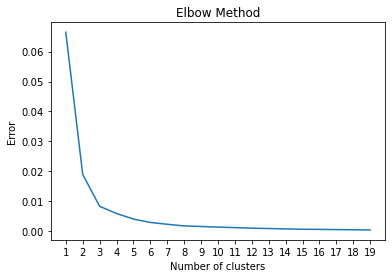

Ideal Number of Clusters is 3


In [19]:
# Need to run the Elbow method to check the number of ideal clusters 
# Change this range if needed

num_clusters = 20 # change this
points = []
for x in range(1, num_clusters):
    kmeans = KMeans(n_clusters=x).fit(finishedData)
    points.append(kmeans.inertia_)

# Plots the data
plt.plot(range(1, num_clusters), points)
plt.xticks(range(1, 20))
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Error')
plt.show()

# Uses KneeLocator to find the elbow on the graph and the number of cluster we should use
x = KneeLocator(range(1, num_clusters), points, curve="convex", direction="decreasing")
print("Ideal Number of Clusters is " + str(x.elbow))

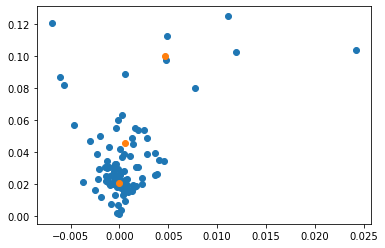

In [20]:
# Runs Kmeans on the data with ideal number of clusters
kmeans = KMeans(n_clusters=x.elbow).fit(finishedData)

# Finds, converts to np.array and prints centriods 
centroids = kmeans.cluster_centers_
centroids = np.array(centroids)
#print(centroids)

# Places the points on scatter plot, blue points are each stock and orange are the centers
plt.scatter(finishedData[:,0], finishedData[:,1])
plt.scatter(centroids[:,0], centroids[:,1])
    

In [25]:
data = pd.DataFrame(data)
data = data.dropna(axis=0, how='any')
data = np.array(data)
# Gets columns Open, Close, Low and High
X = data[:,1:5]
# Gets the number of the stock 
y = data[:,0]
# Splits up the data, can modify the size and random state to give different test and training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5, random_state=2)

# Used to scale the data (uneeded)
"""
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
"""

# Runs KNN
y_pred = KNeighborsClassifier(n_neighbors=12).fit(X_train, y_train).predict(X_test)

# Displays results
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))




[[48  0  0 ...  0  0  0]
 [ 0 33  1 ...  0  0  0]
 [ 1 12  3 ...  0  0  9]
 ...
 [ 0  0  0 ... 41  0  0]
 [ 0  0  0 ...  0  5  0]
 [ 0  0  2 ...  0  0 11]]
              precision    recall  f1-score   support

     42704.0       0.94      1.00      0.97        48
     56422.0       0.39      0.65      0.49        51
     60906.0       0.11      0.05      0.07        57
     65470.0       0.42      0.49      0.45        45
     68960.0       0.36      0.18      0.24        45
     70746.0       0.06      0.02      0.03        57
     73420.0       0.24      0.27      0.25        52
     75639.0       0.29      0.37      0.33        51
     86600.0       0.52      0.64      0.58        50
    103135.0       1.00      1.00      1.00        37
    108420.0       0.35      0.55      0.43        40
    119446.0       1.00      1.00      1.00        41
    122864.0       0.20      0.19      0.19        54
    125293.0       0.67      1.00      0.80        47
    126240.0       0.73      0.92

Text(0, 0.5, 'Mean Error')

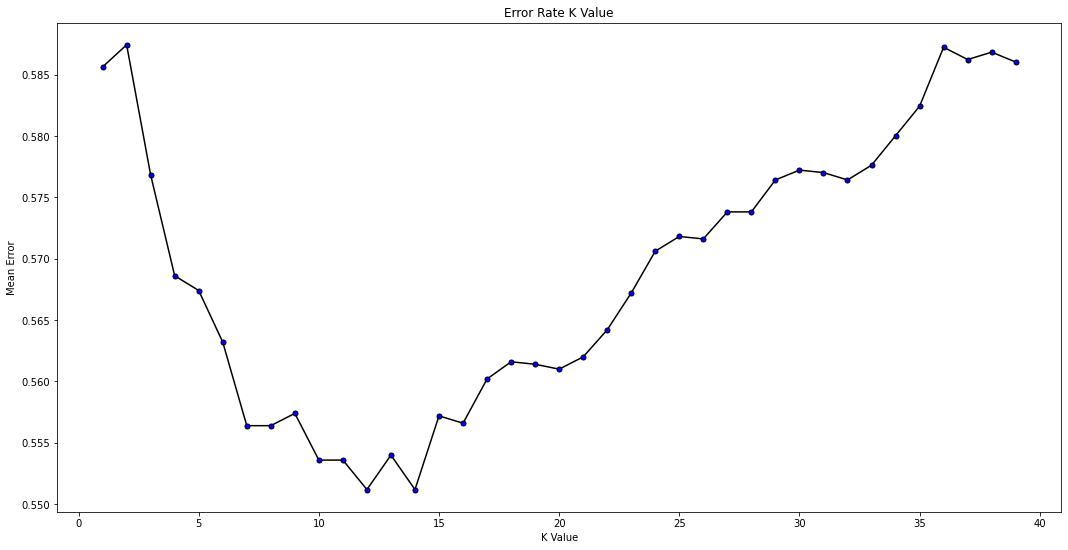

In [23]:
# Plots the Error
error = []

for i in range(1, 40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error.append(np.mean(pred_i != y_test))

plt.figure(figsize=(18, 9))
plt.plot(range(1, 40), error, color='black', linestyle='solid', marker='.',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')